## Deep Learning to Time Series Forecasting with TensorFlow <font color= #922b21 >Recurrent Neural Networks</font>

<img src=https://r2rt.com/static/images/RNN_BasicRNNCell.png height="200" width="260">

### Adapted from:
#### [Applying Deep Learning to Time Series Forecasting with TensorFlow](https://mapr.com/blog/deep-learning-tensorflow/)
#### [RNN Time Series example using Tensorflow](https://github.com/JustinBurg/TensorFlow_TimeSeries_RNN_MapR/blob/master/RNN_Timeseries_Demo.ipynb)
Justin Brandenburg, MapR Technologies

<br>


# * [MSTC](http://mstc.ssr.upm.es/big-data-track) and MUIT: <font size=5 color='green'>Deep Learning with Tensorflow & Keras</font>


In [0]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.contrib.rnn as rnn


# We will try with:
- ## Finantial data $itest='fin'$
- ## or with synthetic sin waves $itest='sin'$

In [0]:
itest='sin'

## <font color='magenta'>First:</font>
- ### get some $Finantial$ data

#### HOW TO GET DATA
##### http://pandas-datareader.readthedocs.io/en/latest/remote_data.html

##### Functions from pandas_datareader.data and pandas_datareader.wb extract data 
##### from various Internet sources into a pandas DataFrame. Currently the following sources are supported:

        Yahoo! Finance
        Google Finance
        Enigma
        Quandl
        St.Louis FED (FRED)
        Kenneth French’s data library
        World Bank
        OECD
        Eurostat
        Thrift Savings Plan
        Nasdaq Trader symbol definitions

In [3]:
! pip install pandas_datareader

    100% |████████████████████████████████| 112kB 4.1MB/s 
    100% |████████████████████████████████| 5.8MB 5.2MB/s 


In [4]:
! pip install fix_yahoo_finance

  Running setup.py bdist_wheel for fix-yahoo-finance ... - done
  Stored in directory: /root/.cache/pip/wheels/2c/ca/ce/218a19aaecf63fd74c75d6a6772b1a799fa05826d8762bfd83
  Running setup.py bdist_wheel for multitasking ... - done
  Stored in directory: /root/.cache/pip/wheels/41/e4/48/af808a1c57f43f104042abdaf80fa623ab213ca0268ba4189c
Successfully built fix-yahoo-finance multitasking


In [0]:
import pandas_datareader as pdr
import datetime

### Get some data from: <font color='green'>FEDEX Stock</font>
      Tray to get some financial data (prices of stocks, ETFs etc.) from Quandl or Yahoo Finance

In [6]:
# Quandl LIMITS the number of access per day!!
import pandas_datareader.data as web
#
symbol = 'WIKI/FDX'  # FEDEX
#
df_aapl = web.DataReader(symbol, 'quandl', '2000-01-01', '2017-01-01')

# Flip is necessary when using pandas_datareader
TS = np.flip(np.array(df_aapl['Close']),0)

ValueError: ignored

In [7]:
import fix_yahoo_finance as yf
df_aapl = yf.download('AAPL', start = '2000-01-01', end='2017-01-01')

# Yahoo symbols
#tickers = ['AAPL','MSFT','GE','IBM','AA','DAL','UAL', 'PEP', 'KO']

TS = np.array(df_aapl['Close'])

[*********************100%***********************]  1 of 1 downloaded


In [8]:
df_aapl.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03
mean,37.806431,38.181446,37.391468,37.793334,30.863950,1.299649e+08
std,39.824205,40.150064,39.466872,39.811876,36.514536,9.970968e+07
min,0.927857,0.942143,0.908571,0.937143,0.627570,9.835000e+06
25%,3.593750,3.709821,3.504464,3.580357,2.397632,6.363350e+07
50%,19.521429,19.781429,19.202858,19.478571,13.044073,1.016484e+08
75%,70.072861,70.781425,69.335716,69.937141,51.926788,1.679636e+08
max,134.460007,134.539993,131.399994,133.000000,124.616013,1.855410e+09


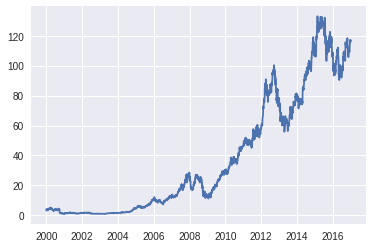

In [9]:
plt.plot(df_aapl['Close'])

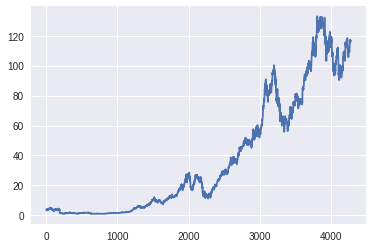

In [11]:
# Chech np.array TS

plt.plot(TS)

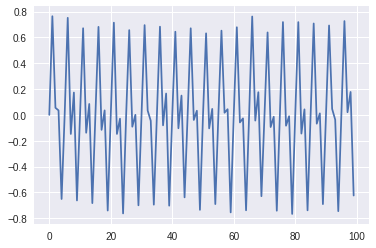

In [12]:
from math import sin
from math import pi
from math import exp
from random import randint
from random import uniform

length=4000
period=5
decay=0.00001

if itest == 'sin':


  def generate_sequence(length, period, decay):
    return [0.5 * sin(2 * pi * i / period*2)*uniform(0.5,1) + \
            0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

  damped_sin = generate_sequence(length, period, decay)

  plt.plot(damped_sin[0:100])

  TS=np.array(damped_sin)

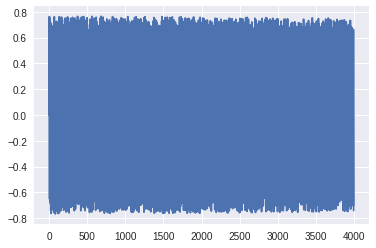

In [13]:
plt.plot(TS)

## Prepare INPUT and OUTPUT (*to be predicted*) DATS

*   y : array with "future" data (ONE element)
*   X: array with "current" data (we avoid the last element)



In [14]:
Y=TS[1:]
X=TS[:-1]

print('X shape ',X.shape)
print('Y shape ',Y.shape)

('X shape ', (3999,))
('Y shape ', (3999,))


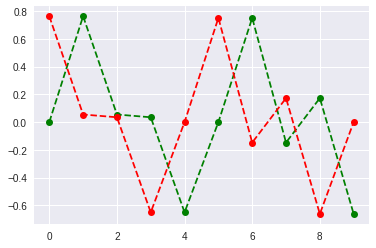

In [15]:
plt.plot(X[0:10],'--o',c='green')
plt.plot(Y[0:10],'--o',c='red')

* <font size='3' >**Convert data into array that can be broken up into training "mini batches" that we will feed into our RNN model.**</font>

      Note the shape of the arrays

- ### $get\_batches$ is an auxiliary function

In [0]:
def get_batches(X, y, batch_size = 10):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

### ... generate batches with a given $num\_steps$ for Truncated Backpropagation

In [0]:
# Generate batches
num_steps=20
x_batches=[]
y_batches=[]
for x,y in get_batches(X, Y, num_steps):
  x_batches.append(x)
  y_batches.append(y)
  
x_batches=np.array(x_batches)
y_batches=np.array(y_batches)

x_batches=x_batches.reshape((x_batches.shape[0],x_batches.shape[1],1))
y_batches=y_batches.reshape((y_batches.shape[0],y_batches.shape[1],1))

In [18]:
print('x batches shape ',x_batches.shape)
print('y batches shape ',y_batches.shape)

('x batches shape ', (199, 20, 1))
('y batches shape ', (199, 20, 1))


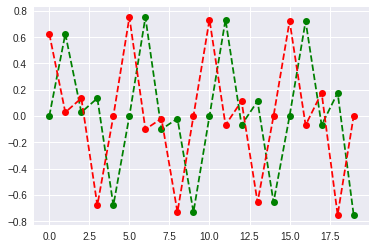

In [19]:
# Plot a given example in batch batch_num
batch_num=10
plt.plot(x_batches[batch_num,:,0],'--o',c='green')
plt.plot(y_batches[batch_num,:,0],'--o',c='red')

### Generate some Test data following a similar process that for Train Data

In [20]:
import fix_yahoo_finance as yf
df_aapl_test = yf.download('FDX', start = '2017-02-01', end='2017-12-31')

TS_test = np.array(df_aapl_test['Close'])

[*********************100%***********************]  1 of 1 downloaded


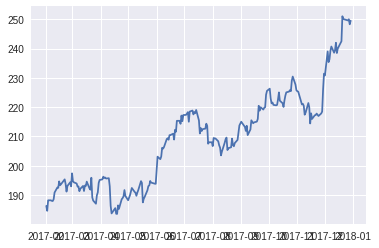

In [21]:
plt.plot(df_aapl_test['Close'])

In [22]:
if itest == 'sin':
  # Generate test data 
  damped_sin = generate_sequence(length, period, decay)
  TS_test=np.array(damped_sin)

y_test=TS_test[1:]
X_test=TS_test[:-1]

print('X_test shape ',X_test.shape)
print('y_test shape ',y_test.shape)

('X_test shape ', (3999,))
('y_test shape ', (3999,))


In [0]:
# Loop over batches

x_test_batches=[]
y_test_batches=[]
for x,y in get_batches(X_test, y_test, num_steps):
  x_test_batches.append(x)
  y_test_batches.append(y)
  
x_test_batches=np.array(x_test_batches)
y_test_batches=np.array(y_test_batches)

x_test_batches=x_test_batches.reshape((x_test_batches.shape[0],x_test_batches.shape[1],1))
y_test_batches=y_test_batches.reshape((y_test_batches.shape[0],y_test_batches.shape[1],1))

In [24]:
print('x_test batches shape ',x_test_batches.shape)
print('y_test batches shape ',y_test_batches.shape)

('x_test batches shape ', (199, 20, 1))
('y_test batches shape ', (199, 20, 1))


## <font color='magenta'>Second:</font>
- ## Graph definition

- ### <font color=99509>We will use a rnn_cell in TENSORFLOW's API</font>
  
        tf.nn.rnn_cell.BasicRNNCell
        tf.nn.rnn_cell.LSTMCell
        tf.nn.rnn_cell.GRUCel
        tf.nn.rnn_cell.MultiRNNCell

* <font size='4' color=99509>**Using a dymanic RNN requires:**</font>
<br>
<br>rnn_inputs = **3-dimnesional** tensor of shape **[batch_size, num_steps, num_inputs (features)]**

from:
[Neural networks and deep learning by Aurélien Géron](https://www.safaribooksonline.com/library/view/neural-networks-and/9781492037354/ch04.html)

<img src=https://www.safaribooksonline.com/library/view/neural-networks-and/9781492037354/assets/mlst_1410.png height="400" width="460" >


In [25]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

#number of steps (already defined) to predict one value ahead
inputs = 1            #input dimension values (in our case is a ONE-dimensional time series)
state_size = 100          #number of state neurons
output = 1            #output dimension: output will be a ONE-dimensional time series

X_tf = tf.placeholder(tf.float32, [None, num_steps, inputs])   #input batches
y_tf = tf.placeholder(tf.float32, [None, num_steps, output])   #ouput batches (same number of steps)


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size, activation=tf.nn.relu)   #create our RNN object
rnn_output, final_state = tf.nn.dynamic_rnn(basic_cell, X_tf, dtype=tf.float32) #choose dynamic over static

#LSTM
#cell = tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True)
#cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)

# GRU
#cell = tf.nn.rnn_cell.GRUCell(state_size)

#init_state = cell.zero_state(batch_size, tf.float32)
#rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
#init_state = cell.zero_state(batch_size, tf.float32)

#rnn_output, final_state = tf.nn.dynamic_rnn(cell, X_tf, dtype=tf.float32)

######### SEE FIGURE ABOVE TO UNDERSTAND THESE RESHAPES...###
stacked_rnn_output = tf.reshape(rnn_output, [-1, state_size])   #change the form to have ALL output states from ALL batches
                                                                #stacked : Thew will be processed at once to get ALL outputs
                                                                #using a denselayer
    
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)       #specify the type of layer (dense)

outputs = tf.reshape(stacked_outputs, [-1, num_steps, output])    #Once we have ALL outputs corresponding to the batch
                                                                  #Re-shape them to give the initial shape [no. batches,num_steps,num_outputs]

##############END OF RESHAPES ###############################3
  
loss = tf.reduce_sum(tf.square(outputs - y_tf))    #define the cost function
                                                #in this case the SUM of SQUARED difference between output and labels (y)
                                                #for ALL samples in each batch
                                                #WE COULD ONLY USE THE LAST OUTPUT? ...or some of then?

learning_rate = 0.01   #small learning rate so we don't overshoot the minimum
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables


Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


## <font color='magenta'>Third:</font>
- ### Train and predict future values (Test)</font>

In [26]:
epochs = 2000     #number of iterations or training cycles, 
                  #includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X_tf: x_batches, y_tf: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X_tf: x_batches, y_tf: y_batches})
            mse_test = loss.eval(feed_dict={X_tf: x_test_batches, y_tf: y_test_batches})
            print(ep, "\nMSE train:", mse, 'MSE test: ', mse_test)
    
    y_pred = sess.run(outputs, feed_dict={X_tf: x_test_batches})
    y_pred_train = sess.run(outputs, feed_dict={X_tf: x_batches})
    # print(y_pred)
    
    # Generate a sequence
    gen_seq = [0.] * num_steps # a initial list of num_steps input zero values
    for iteration in range(600):
      X_batch = np.array(gen_seq[-num_steps:]).reshape(1, num_steps, 1)
      # X_batch contains last num_steps in seg_sec
      
      y_gen = sess.run(outputs, feed_dict={X_tf: X_batch}) # gets the output of
                                                           # a single batch
        
      gen_seq.append(y_gen[0, -1, 0]) # we only add to gen_seq the last output
        
      
   

(0, '\nMSE train:', 623.0404, 'MSE test: ', 625.70575)
(100, '\nMSE train:', 11.175747, 'MSE test: ', 11.318022)
(200, '\nMSE train:', 10.650728, 'MSE test: ', 10.7969265)
(300, '\nMSE train:', 10.483963, 'MSE test: ', 10.653997)
(400, '\nMSE train:', 10.898846, 'MSE test: ', 11.043801)
(500, '\nMSE train:', 10.351939, 'MSE test: ', 10.599302)
(600, '\nMSE train:', 10.360643, 'MSE test: ', 10.61097)
(700, '\nMSE train:', 10.321691, 'MSE test: ', 10.60886)
(800, '\nMSE train:', 10.339014, 'MSE test: ', 10.621507)
(900, '\nMSE train:', 10.293488, 'MSE test: ', 10.638056)
(1000, '\nMSE train:', 10.363888, 'MSE test: ', 10.707369)
(1100, '\nMSE train:', 10.272838, 'MSE test: ', 10.675173)
(1200, '\nMSE train:', 10.268483, 'MSE test: ', 10.742362)
(1300, '\nMSE train:', 10.206996, 'MSE test: ', 10.709391)
(1400, '\nMSE train:', 10.521795, 'MSE test: ', 11.147052)
(1500, '\nMSE train:', 10.245033, 'MSE test: ', 10.876615)
(1600, '\nMSE train:', 10.177725, 'MSE test: ', 10.804392)
(1700, '\nM

- ### Compare on a Train batch: input(blue), predicted(red), truth(green)

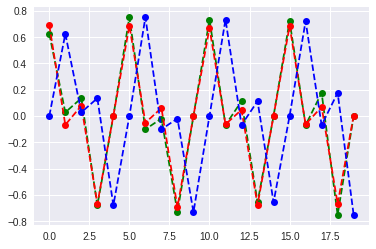

In [27]:
# Plot a given example in batch batch_num
batch_num=10
plt.plot(y_batches[batch_num,:,0],'--o',c='green')
plt.plot(y_pred_train[batch_num,:,0],'--o',c='red')
plt.plot(x_batches[batch_num,:,0],'--o',c='blue')

- ### Compare on a Test batch: input(blue), predicted(red), truth(green)

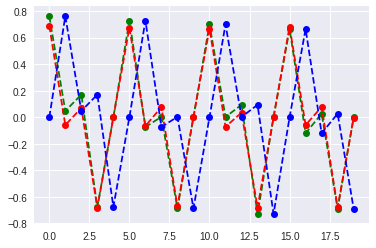

In [28]:
# Plot a given example in batch batch_num
batch_num=2
plt.plot(y_test_batches[batch_num,:,0],'--o',c='green')
plt.plot(y_pred[batch_num,:,0],'--o',c='red')
plt.plot(x_test_batches[batch_num,:,0],'--o',c='blue')

- ### Plot a generated sequence...

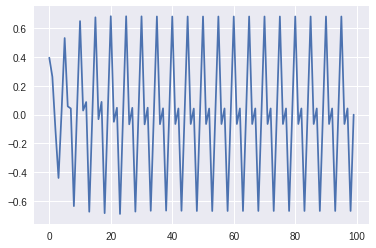

In [29]:
plt.plot(gen_seq[100:200])

## <font color='magenta'>Try different RNN types and hyper-parameters...</font>

## [You can also follow this illustrative example in Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)